In [1]:
import numpy as np
np.set_printoptions(precision=7)
np.set_printoptions(suppress=True)
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

In [2]:
file_path = 'data.csv'
df = pd.read_csv(file_path)

In [3]:
# preprocessing: separating the IDs and numerical values
customer_id = df[['CUST_ID']].copy()
df = df[df.columns[~df.columns.isin(['CUST_ID'])]]

In [4]:
df.isna().sum()

BALANCE                               0
BALANCE_FREQUENCY                     0
PURCHASES                             0
ONEOFF_PURCHASES                      0
INSTALLMENTS_PURCHASES                0
CASH_ADVANCE                          0
PURCHASES_FREQUENCY                   0
ONEOFF_PURCHASES_FREQUENCY            0
PURCHASES_INSTALLMENTS_FREQUENCY      0
CASH_ADVANCE_FREQUENCY                0
CASH_ADVANCE_TRX                      0
PURCHASES_TRX                         0
CREDIT_LIMIT                          1
PAYMENTS                              0
MINIMUM_PAYMENTS                    313
PRC_FULL_PAYMENT                      0
TENURE                                0
dtype: int64

In [5]:
df.fillna(df.median(), inplace=True)
df.head()

,BALANCE,BALANCE_FREQUENCY,PURCHASES,ONEOFF_PURCHASES,INSTALLMENTS_PURCHASES,CASH_ADVANCE,PURCHASES_FREQUENCY,ONEOFF_PURCHASES_FREQUENCY,PURCHASES_INSTALLMENTS_FREQUENCY,CASH_ADVANCE_FREQUENCY,CASH_ADVANCE_TRX,PURCHASES_TRX,CREDIT_LIMIT,PAYMENTS,MINIMUM_PAYMENTS,PRC_FULL_PAYMENT,TENURE
0,40.900749,0.818182,95.40,0.00,95.4,0.000000,0.166667,0.000000,0.083333,0.000000,0,2,1000.0,201.802084,139.509787,0.000000,12
1,3202.467416,0.909091,0.00,0.00,0.0,6442.945483,0.000000,0.000000,0.000000,0.250000,4,0,7000.0,4103.032597,1072.340217,0.222222,12
2,2495.148862,1.000000,773.17,773.17,0.0,0.000000,1.000000,1.000000,0.000000,0.000000,0,12,7500.0,622.066742,627.284787,0.000000,12
3,1666.670542,0.636364,1499.00,1499.00,0.0,205.788017,0.083333,0.083333,0.000000,0.083333,1,1,7500.0,0.000000,312.343947,0.000000,12
4,817.714335,1.000000,16.00,16.00,0.0,0.000000,0.083333,0.083333,0.000000,0.000000,0,1,1200.0,678.334763,244.791237,0.000000,12


# A. Data exploration: Histograms

In [6]:
def plot_hist_feature(data, title, number=None, nbins=50):
    plt.figure(figsize=(7, 4))
    plt.hist(data, nbins)
    plt.xlabel('Value', fontsize=14)
    plt.ylabel('Frequency', fontsize=14)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.title(f"Histogram {number} - {title}", fontsize=17)
    
    plt.show()

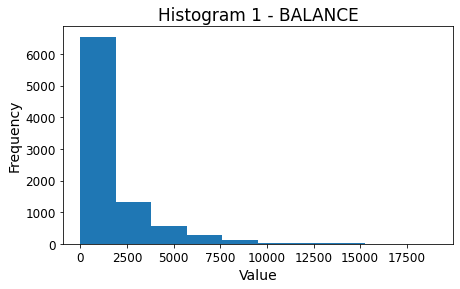

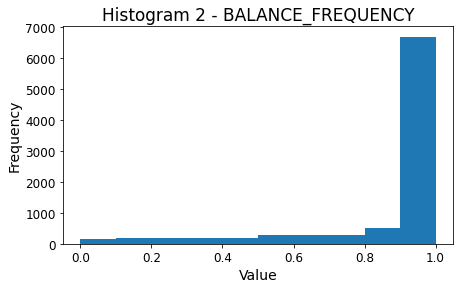

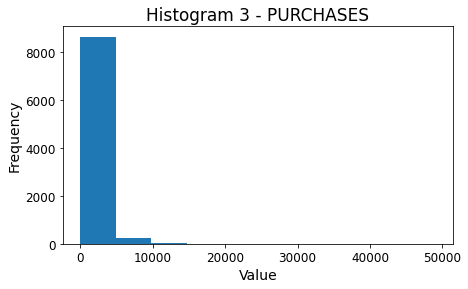

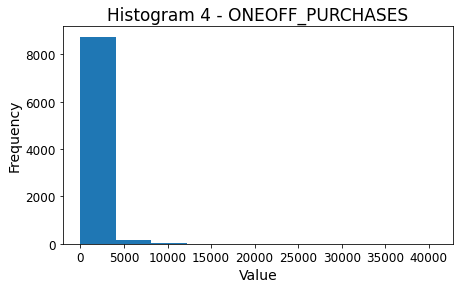

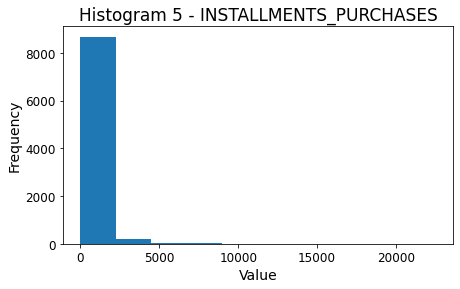

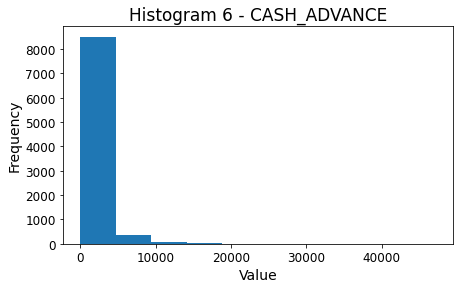

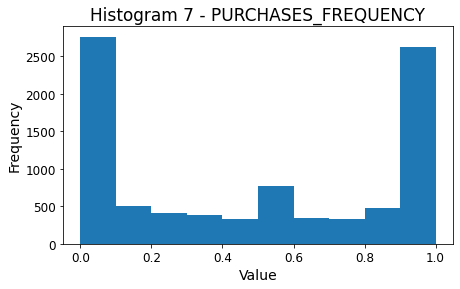

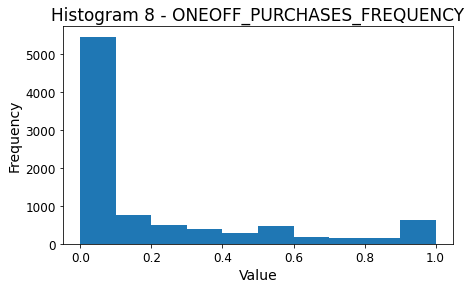

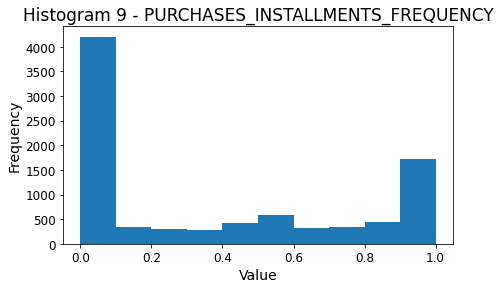

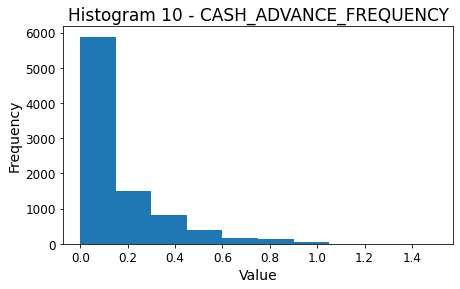

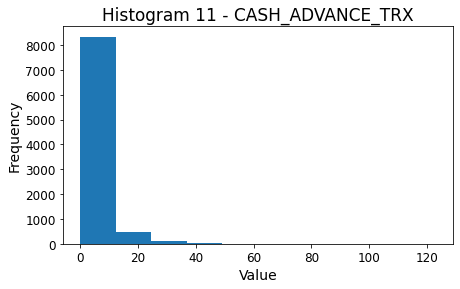

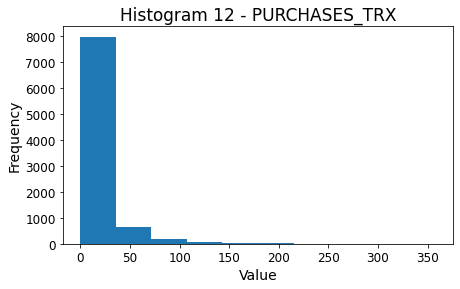

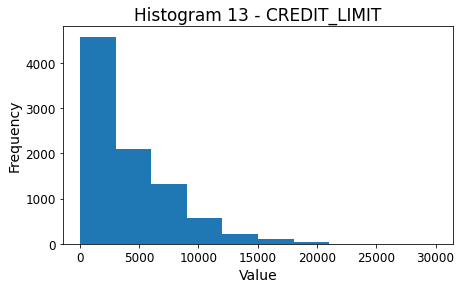

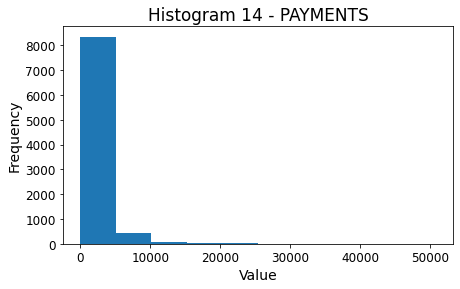

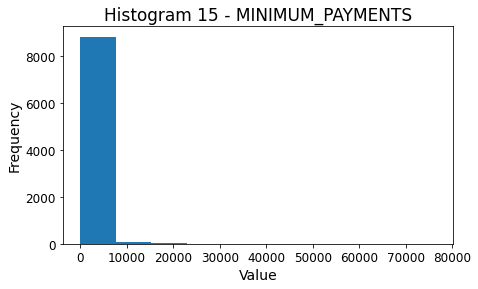

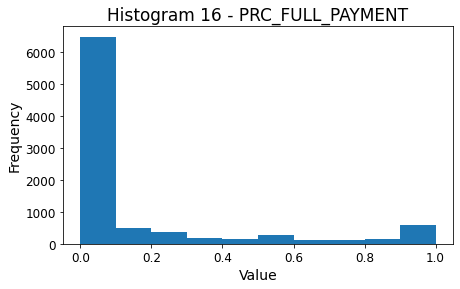

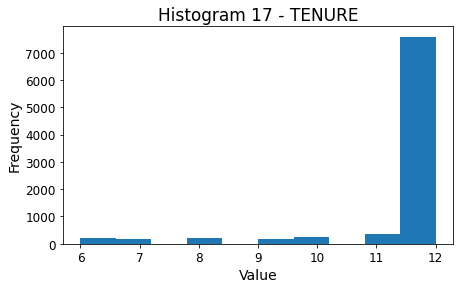

In [7]:
for i, feature in enumerate(df.columns):
    plot_hist_feature(df[feature], feature, i+1, nbins=None)

Data is highly skew, so the median imputation makes sense and preserves the mean well

In [8]:
df.skew().abs() < 3

BALANCE                              True
BALANCE_FREQUENCY                    True
PURCHASES                           False
ONEOFF_PURCHASES                    False
INSTALLMENTS_PURCHASES              False
CASH_ADVANCE                        False
PURCHASES_FREQUENCY                  True
ONEOFF_PURCHASES_FREQUENCY           True
PURCHASES_INSTALLMENTS_FREQUENCY     True
CASH_ADVANCE_FREQUENCY               True
CASH_ADVANCE_TRX                    False
PURCHASES_TRX                       False
CREDIT_LIMIT                         True
PAYMENTS                            False
MINIMUM_PAYMENTS                    False
PRC_FULL_PAYMENT                     True
TENURE                               True
dtype: bool

# B. Data exploration: Feature's correlation

In [9]:
def get_pearson_coeff(dataframe, feature1, feature2):
    '''
    Given 2 feature names return the Pearson’s correlation coefficient between them
    '''
    ### YOUR CODE HERE
    x = dataframe[feature1]
    y = dataframe[feature2]
    return stats.pearsonr(x, y)[0]

In [10]:
corrs = np.zeros((17, 17))
correlations = []

for i, feature1 in enumerate(df.columns):
    for j, feature2 in enumerate(df.columns):
        if i > j:
            continue
        corr = get_pearson_coeff(df, feature1, feature2)
        corrs[i, j] = corr
        corrs[j, i] = corr
        correlations.append([feature1, feature2, corr])
        
correlations = pd.DataFrame(data=correlations, columns=['feature1', 'feature2', 'value'])

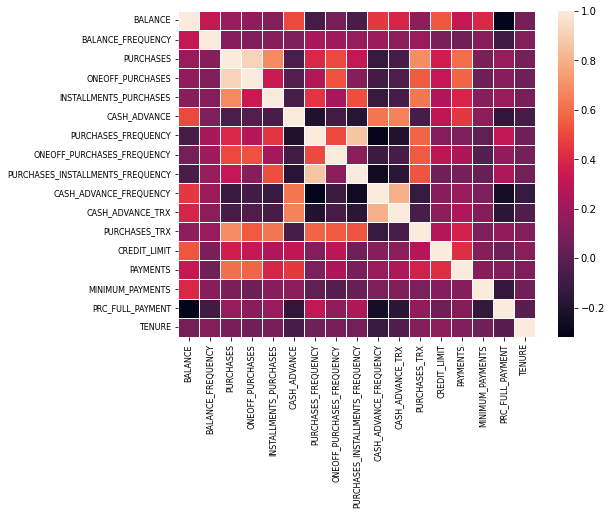

In [11]:
plt.figure(figsize=(8,6))
sns.heatmap(corrs, linewidths=.5)
plt.xticks(np.arange(17)+0.5, df.columns, rotation=90, fontsize=8)
plt.yticks(np.arange(17)+0.5, df.columns, rotation=0,fontsize=8)
plt.show()

In [12]:
correlations[(correlations.value.abs() > 0.6) & (correlations.feature1 != correlations.feature2)]

,feature1,feature2,value
34,PURCHASES,ONEOFF_PURCHASES,0.916845
35,PURCHASES,INSTALLMENTS_PURCHASES,0.679896
42,PURCHASES,PURCHASES_TRX,0.689561
44,PURCHASES,PAYMENTS,0.603264
69,INSTALLMENTS_PURCHASES,PURCHASES_TRX,0.628108
79,CASH_ADVANCE,CASH_ADVANCE_FREQUENCY,0.628522
80,CASH_ADVANCE,CASH_ADVANCE_TRX,0.656498
89,PURCHASES_FREQUENCY,PURCHASES_INSTALLMENTS_FREQUENCY,0.862934
118,CASH_ADVANCE_FREQUENCY,CASH_ADVANCE_TRX,0.799561


The correlation does not tell much information about the dataset. i.e. the highest
corrleation shows only dependency between purchases and oneoff_purchases that makes
sense. Therefore, we choose to use a threshold of 0.7

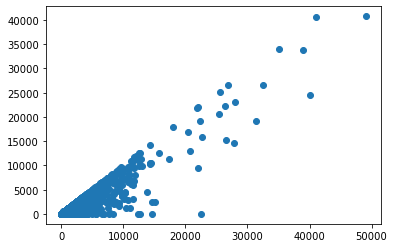

In [13]:
plt.figure()
plt.scatter(df.PURCHASES, df.ONEOFF_PURCHASES)
plt.show()

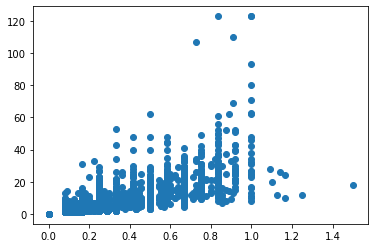

In [14]:
plt.figure()
plt.scatter(df.CASH_ADVANCE_FREQUENCY, df.CASH_ADVANCE_TRX)
plt.show()

# C. K-means clustering: Find optimal K using feature 2-16

In [15]:
def calculate_optimal_k(inertias, threshold=0.1):
    for i, inertia in enumerate(inertias):
        if i == len(inertias) - 2:
            print(f'No optimal K has been found using {threshold}')
            break

        slope = inertias[i+1] - inertia
        next_slope = inertias[i+2] - inertias[i+1]
        # variation = 100 * abs((next_slope - slope) / slope)
        variation = next_slope / slope
        print(i+1, variation)
        if variation < 1 + threshold and variation> 1 - threshold:
            return i+1

        # if variation < threshold:
        #     return i+1

In [16]:
def plot_elbow_method(inertias, optimal_number):
    plt.figure(figsize=(7, 5))
    plt.plot(range(1, len(inertias)+1), inertias, 'bo--')
    plt.axvline(x=optimal_number, linestyle='dashed', c='red')
    plt.title('Elbow method', fontsize=17)
    plt.xlabel('Number of clusters K', fontsize=14)
    plt.ylabel('Inertia', fontsize=14)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.xlim([0, len(inertias)+1])
    plt.grid()
    plt.show()

In [17]:
# First, we normalize the dataset to 0 mean and 1 standard deviation

sc = StandardScaler()
X = sc.fit_transform(df[df.columns[0:15]])

In [18]:
inertias = []

for k in range(1, 15):
    kmeans = KMeans(n_clusters=k, random_state=123, init='k-means++')
    kmeans.fit(X)
    inertias.append(kmeans.inertia_)

In [19]:
k_optimal = calculate_optimal_k(inertias, threshold=0.05)
k_optimal

1 0.6836757778655286
2 0.783637654970899
3 0.5935073738181699
4 0.8380997551953504
5 0.8326961654300766
6 0.8899723304153125
7 0.7390414278019519
8 0.7206912979396419
9 0.9514871732153446


9

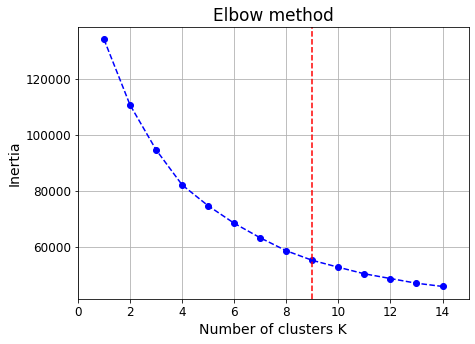

In [20]:
plot_elbow_method(inertias, k_optimal)

The elbow method using features 2-16 does not show a clear optimal K. It looks like
an smooth curve instead. Nvertheless, the optimial K* in this case is 9

In [21]:
# 11 cluster, but looks so many
kmeans = KMeans(n_clusters=k_optimal, random_state=123, init='k-means++')
kmeans.fit(X)
df['label_full_features'] = kmeans.labels_

In [22]:
# number of users on each clusters
values, counts = np.unique(kmeans.labels_, return_counts=True)

heading = '{:9s} {}'.format('cluster', '#users')
print(heading)
print('-' * len(heading))

for value, count in zip(values, counts):
    print('{:7} {:8.0f}'.format(value, count))

cluster   #users
----------------
      0     1304
      1     2592
      2       23
      3      385
      4     2206
      5     1211
      6      117
      7     1075
      8       37


In [23]:
# centroid of each cluster

cluster_id = pd.DataFrame(data=np.arange(k_optimal), columns=['cluster_id'])
centroids = pd.DataFrame(data=kmeans.cluster_centers_, columns=df.columns[0:15])
centroids = pd.concat((cluster_id, centroids), axis=1)
centroids

,cluster_id,BALANCE,BALANCE_FREQUENCY,PURCHASES,ONEOFF_PURCHASES,INSTALLMENTS_PURCHASES,CASH_ADVANCE,PURCHASES_FREQUENCY,ONEOFF_PURCHASES_FREQUENCY,PURCHASES_INSTALLMENTS_FREQUENCY,CASH_ADVANCE_FREQUENCY,CASH_ADVANCE_TRX,PURCHASES_TRX,CREDIT_LIMIT,PAYMENTS,MINIMUM_PAYMENTS
0,0,-0.694554,-2.128966,-0.314461,-0.234499,-0.312624,-0.305991,-0.571957,-0.437749,-0.462564,-0.484464,-0.360549,-0.427785,-0.207830,-0.219280,-0.284137
1,1,-0.090531,0.372255,-0.367260,-0.248348,-0.412013,-0.134726,-0.894242,-0.407830,-0.790936,0.061429,-0.083781,-0.497643,-0.401720,-0.285547,-0.082494
2,2,1.865907,0.332878,12.596844,13.111182,5.696389,-0.004178,1.033322,2.170634,0.866221,-0.476183,-0.214854,4.566558,3.174213,8.991136,1.072085
3,3,0.958373,0.462940,2.420363,1.787757,2.438485,-0.189874,1.162018,1.574035,1.263452,-0.301214,-0.190610,2.974997,1.268811,1.342799,0.350501
4,4,-0.390202,0.312592,-0.065854,-0.255321,0.313311,-0.364224,0.964854,-0.410356,1.157368,-0.463608,-0.359332,0.131366,-0.319043,-0.248025,-0.097842
5,5,-0.119164,0.389389,0.483361,0.616726,0.009741,-0.323740,0.934160,1.826775,0.131810,-0.397573,-0.324928,0.551852,0.401214,0.101097,-0.144989
6,6,1.952861,0.272229,0.136855,0.118203,0.106051,5.073267,-0.236796,0.018648,-0.165875,2.459708,3.998912,0.107954,1.569467,3.900181,0.603955
7,7,1.355858,0.386705,-0.290847,-0.210236,-0.301513,1.324503,-0.594527,-0.291157,-0.518144,1.697580,1.382551,-0.353365,0.731427,0.255634,0.298202
8,8,1.299171,0.455853,-0.051371,-0.271244,0.376157,-0.010364,-0.011158,-0.532469,0.230336,-0.241518,-0.060225,0.197608,0.006400,-0.092120,11.482043


In [24]:
# scatter average distance to each cluster

data = []
for i in range(k_optimal):
    center = kmeans.cluster_centers_[i]
    instances = X[kmeans.labels_ == i]
    n_instances, _ = instances.shape
    centers = np.repeat(center.reshape(1, 15), n_instances, axis=0)
    
    distances2 = np.power(instances - centers, 2).sum(axis=1)
    distances = np.power(distances2, 0.5)
    
    data.append([i, distances.mean(), np.median(distances), distances.min(), distances.max()])
    
scatters = pd.DataFrame(data=data, columns=['cluster_id', 'mean_dist', 'median_dist', 'min_dist', 'max_dist'])
scatters

,cluster_id,mean_dist,median_dist,min_dist,max_dist
0,0,1.692106,1.480724,0.462322,10.125139
1,1,1.476110,1.355048,0.483212,5.641121
2,2,9.450136,9.163247,2.807406,16.949201
3,3,4.438228,3.779448,1.443013,24.102850
4,4,1.639290,1.417961,0.631581,5.810881
5,5,2.324137,2.171382,0.828447,6.842243
6,6,5.879152,5.170271,2.464259,23.887353
7,7,2.890812,2.712647,1.053671,8.028073
8,8,5.574530,4.810230,1.598035,22.860181


In [25]:
from sklearn.decomposition import PCA
pca = PCA(n_components=3, svd_solver='randomized', random_state=123)
pca.fit(X)
pca_x = pca.transform(X)

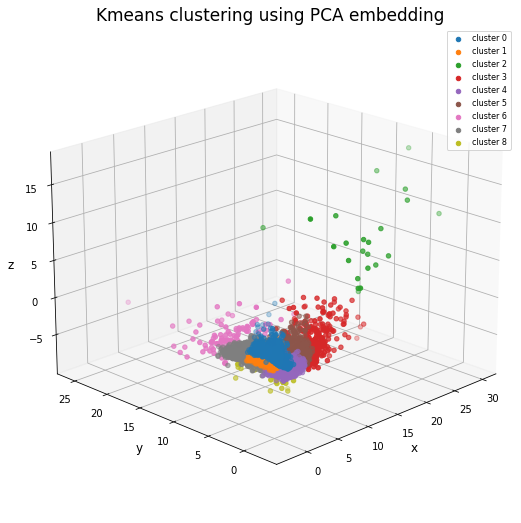

In [26]:
fig = plt.figure(figsize=(9, 9))
ax = fig.add_subplot(projection='3d')
ax.view_init(elev=20, azim=-135, vertical_axis='z')

for i in range(k_optimal):
    mask = df['label_full_features'] == i
    ax.scatter3D(pca_x[mask, 0], pca_x[mask, 1], pca_x[mask, 2], label="cluster {}".format(i))

ax.set_title("Kmeans clustering using PCA embedding", fontsize=17)
ax.set_xlabel('x', fontsize=12)
ax.set_ylabel('y', fontsize=12)
ax.set_zlabel('z', fontsize=12)
# ax.set_xticks([-160, -80, 0, 80, 160, 240])
# ax.set_yticks([-40, 0, 40, 80])
# ax.set_zticks([-40, 0, 40, 80])
plt.legend(fontsize=8)
plt.show()

## Discussion

In [27]:
df[['PRC_FULL_PAYMENT', 'TENURE', 'label_full_features']].groupby(by=['label_full_features']).aggregate({'mean', 'std'})

PRC_FULL_PAYMENT              TENURE           
                                 std      mean       std       mean
label_full_features                                                
0                           0.348506  0.229026  1.495343  11.368865
1                           0.072818  0.024508  1.328593  11.513503
2                           0.414354  0.515316  0.417029  11.913043
3                           0.372860  0.243378  0.366184  11.963636
4                           0.341245  0.249603  1.415951  11.482774
5                           0.362281  0.258126  1.020404  11.724195
6                           0.176053  0.115172  1.310031  11.538462
7                           0.093164  0.029145  1.497260  11.360000
8                           0.000000  0.000000  0.276725  11.918919

The selected features are:

In [28]:
select_features = ['BALANCE', 'BALANCE_FREQUENCY', 'PURCHASES_FREQUENCY', 'ONEOFF_PURCHASES_FREQUENCY',
                   'PURCHASES_INSTALLMENTS_FREQUENCY', 'CASH_ADVANCE_FREQUENCY', 'CREDIT_LIMIT']

# D. K-means clustering: Using only non-correlated and less skewed features

In [29]:
sc = StandardScaler()
X = sc.fit_transform(df[select_features])

In [30]:
inertias = []

for k in range(1, 15):
    kmeans = KMeans(n_clusters=k, random_state=123, init='k-means++')
    kmeans.fit(X)
    inertias.append(kmeans.inertia_)

In [31]:
k_optimal = calculate_optimal_k(inertias, threshold=0.05)
k_optimal

1 0.5106808884594216
2 0.7621363445776084
3 0.9127372088511734
4 0.4272753378149273
5 0.6237585041983961
6 0.7232697854260725
7 1.0433162241815575


7

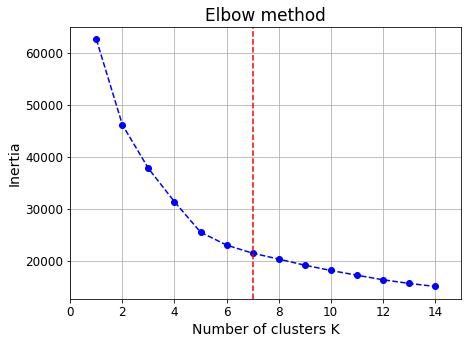

In [32]:
plot_elbow_method(inertias, k_optimal)

In [33]:
# 11 cluster, but looks so many
kmeans = KMeans(n_clusters=k_optimal, random_state=123, init='k-means++')
kmeans.fit(X)
df['label_selected_features'] = kmeans.labels_

In [34]:
# number of users on each clusters
values, counts = np.unique(kmeans.labels_, return_counts=True)

heading = '{:9s} {}'.format('cluster', '#users')
print(heading)
print('-' * len(heading))

for value, count in zip(values, counts):
    print('{:7} {:8.0f}'.format(value, count))

cluster   #users
----------------
      0     2297
      1      494
      2     1289
      3      860
      4     2233
      5      581
      6     1196


In [35]:
# centroid of each cluster

cluster_id = pd.DataFrame(data=np.arange(k_optimal), columns=['cluster_id'])
centroids = pd.DataFrame(data=kmeans.cluster_centers_, columns=select_features)
centroids = pd.concat((cluster_id, centroids), axis=1)
centroids

,cluster_id,BALANCE,BALANCE_FREQUENCY,PURCHASES_FREQUENCY,ONEOFF_PURCHASES_FREQUENCY,PURCHASES_INSTALLMENTS_FREQUENCY,CASH_ADVANCE_FREQUENCY,CREDIT_LIMIT
0,0,-0.136670,0.355745,-0.833518,-0.377940,-0.751931,-0.192963,-0.377996
1,1,1.888157,0.458611,1.035699,0.964075,1.038263,0.431558,1.878792
2,2,-0.686613,-2.164384,-0.586803,-0.446668,-0.469703,-0.462966,-0.196087
3,3,0.150275,0.338084,-0.859068,-0.403182,-0.742357,1.816436,-0.273863
4,4,-0.394597,0.316467,0.993384,-0.378175,1.190176,-0.453685,-0.345906
5,5,2.234024,0.464839,-0.885074,-0.431588,-0.764306,1.356100,1.359897
6,6,-0.236047,0.400195,1.000026,2.016748,0.205289,-0.428032,0.342560


In [36]:
# scatter average distance to each cluster

data = []
for i in range(k_optimal):
    center = kmeans.cluster_centers_[i]
    instances = X[kmeans.labels_ == i]
    n_instances, _ = instances.shape
    centers = np.repeat(center.reshape(1, len(select_features)), n_instances, axis=0)
    
    distances2 = np.power(instances - centers, 2).sum(axis=1)
    distances = np.power(distances2, 0.5)
    
    data.append([i, distances.mean(), np.median(distances), distances.min(), distances.max()])
    
scatters = pd.DataFrame(data=data, columns=['cluster_id', 'mean_dist', 'median_dist', 'min_dist', 'max_dist'])
scatters

,cluster_id,mean_dist,median_dist,min_dist,max_dist
0,0,1.125581,1.039565,0.263589,3.760579
1,1,2.431783,2.229932,0.463837,7.022206
2,2,1.441818,1.312032,0.327555,5.333726
3,3,1.382057,1.192908,0.401496,5.151732
4,4,1.185847,1.009645,0.411639,3.470511
5,5,1.780535,1.614234,0.392691,6.121313
6,6,1.680187,1.643868,0.390022,4.249631


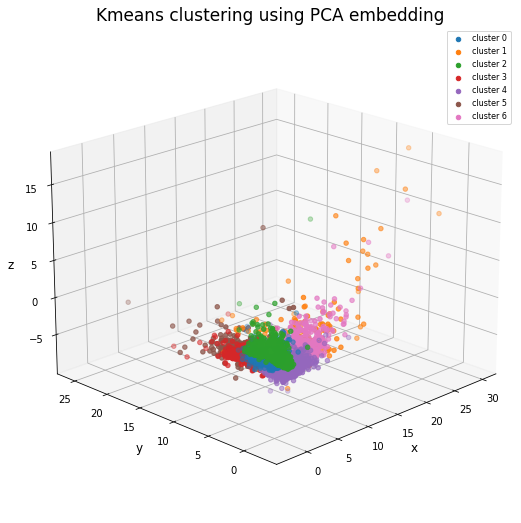

In [37]:
fig = plt.figure(figsize=(9, 9))
ax = fig.add_subplot(projection='3d')
ax.view_init(elev=20, azim=-135, vertical_axis='z')

for i in range(k_optimal):
    mask = df['label_selected_features'] == i
    ax.scatter3D(pca_x[mask, 0], pca_x[mask, 1], pca_x[mask, 2], label="cluster {}".format(i))

ax.set_title("Kmeans clustering using PCA embedding", fontsize=17)
ax.set_xlabel('x', fontsize=12)
ax.set_ylabel('y', fontsize=12)
ax.set_zlabel('z', fontsize=12)
# ax.set_xticks([-160, -80, 0, 80, 160, 240])
# ax.set_yticks([-40, 0, 40, 80])
# ax.set_zticks([-40, 0, 40, 80])
plt.legend(fontsize=8)
plt.show()

## Discussion

In [38]:
df[['PRC_FULL_PAYMENT', 'TENURE', 'label_selected_features']].groupby(by=['label_selected_features']).aggregate({'mean', 'std'})

PRC_FULL_PAYMENT              TENURE           
                                     std      mean       std       mean
label_selected_features                                                
0                               0.099765  0.032488  1.198148  11.589029
1                               0.210234  0.069383  0.797713  11.836032
2                               0.349341  0.228499  1.485441  11.374709
3                               0.107784  0.042200  1.830332  11.051163
4                               0.343587  0.253708  1.409736  11.485446
5                               0.037513  0.009722  1.130835  11.628227
6                               0.380362  0.304215  0.992306  11.742475

## UMAP

In [233]:
sc = StandardScaler()
X = sc.fit_transform(df[select_features])

In [234]:
X.shape

(8950, 7)

In [39]:
sc = StandardScaler()
X = sc.fit_transform(df[df.columns[0:15]])

In [40]:
X.shape

(8950, 15)

In [41]:
from umap import UMAP

umap = UMAP(n_components=4, n_neighbors=10, min_dist=0.05, random_state=123)
umap_x = umap.fit_transform(X)

C:\Users\Cristhian\software\anaconda3\lib\site-packages\umap\umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


In [42]:
inertias = []

for k in range(1, 15):
    kmeans = KMeans(n_clusters=k, random_state=123, init='k-means++')
    kmeans.fit(umap_x)
    inertias.append(kmeans.inertia_)

In [43]:
k_optimal = calculate_optimal_k(inertias, threshold=0.06)
k_optimal

1 0.3405142435523977
2 0.39592469677660386
3 0.8495398745084712
4 0.8739279932927314
5 0.4650887174965595
6 0.9067720003514784
7 0.943594147740659


7

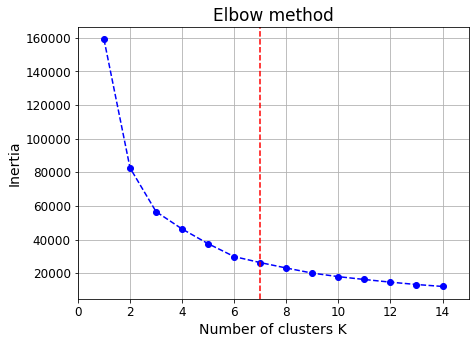

In [44]:
plot_elbow_method(inertias, k_optimal)

In [48]:
k_optimal = 8

In [49]:
# 11 cluster, but looks so many
kmeans = KMeans(n_clusters=k_optimal, random_state=123, init='k-means++')
kmeans.fit(umap_x)
df['umap_seleted_features'] = kmeans.labels_

In [50]:
# number of users on each clusters
values, counts = np.unique(kmeans.labels_, return_counts=True)

heading = '{:9s} {}'.format('cluster', '#users')
print(heading)
print('-' * len(heading))

for value, count in zip(values, counts):
    print('{:7} {:8.0f}'.format(value, count))

cluster   #users
----------------
      0     1275
      1     1531
      2      699
      3     1346
      4     1488
      5     1325
      6     1145
      7      141


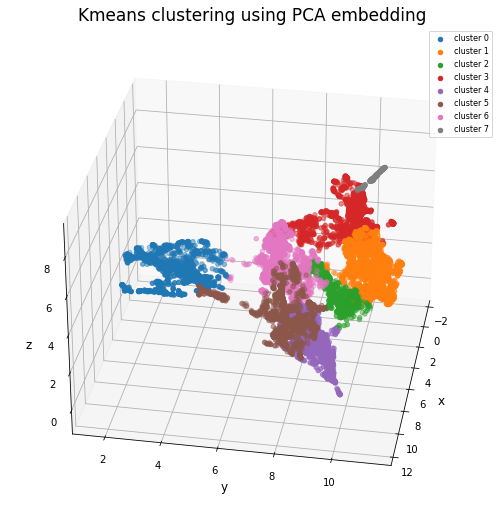

In [56]:
fig = plt.figure(figsize=(9, 9))
ax = fig.add_subplot(projection='3d')
ax.view_init(elev=30, azim=10, vertical_axis='z')

for i in range(k_optimal):
    mask = df['umap_seleted_features'] == i
    ax.scatter3D(umap_x[mask, 0], umap_x[mask, 1], umap_x[mask, 2], label="cluster {}".format(i))

ax.set_title("Kmeans clustering using PCA embedding", fontsize=17)
ax.set_xlabel('x', fontsize=12)
ax.set_ylabel('y', fontsize=12)
ax.set_zlabel('z', fontsize=12)
# ax.set_xticks([-160, -80, 0, 80, 160, 240])
# ax.set_yticks([-40, 0, 40, 80])
# ax.set_zticks([-40, 0, 40, 80])
plt.legend(fontsize=8)
plt.show()

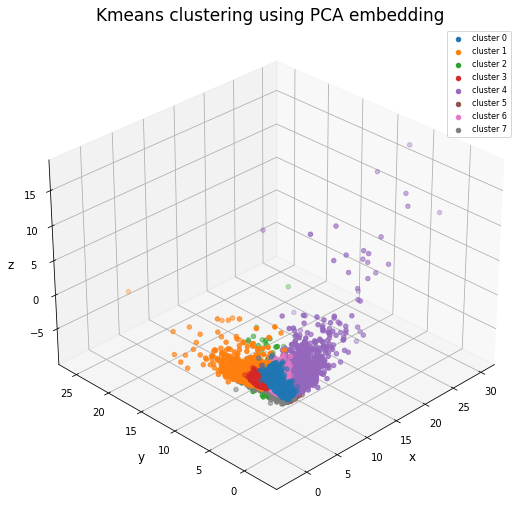

In [69]:
fig = plt.figure(figsize=(9, 9))
ax = fig.add_subplot(projection='3d')
ax.view_init(elev=30, azim=-135, vertical_axis='z')

for i in range(k_optimal):
    mask = df['umap_seleted_features'] == i
    ax.scatter3D(pca_x[mask, 0], pca_x[mask, 1], pca_x[mask, 2], label="cluster {}".format(i))

ax.set_title("Kmeans clustering using PCA embedding", fontsize=17)
ax.set_xlabel('x', fontsize=12)
ax.set_ylabel('y', fontsize=12)
ax.set_zlabel('z', fontsize=12)
# ax.set_xticks([-160, -80, 0, 80, 160, 240])
# ax.set_yticks([-40, 0, 40, 80])
# ax.set_zticks([-40, 0, 40, 80])
plt.legend(fontsize=8)
plt.show()

In [70]:
df[['PRC_FULL_PAYMENT', 'TENURE', 'umap_seleted_features']].groupby(by=['umap_seleted_features']).aggregate({'mean', 'std'})

PRC_FULL_PAYMENT              TENURE           
                                   std      mean       std       mean
umap_seleted_features                                                
0                             0.354572  0.260113  1.363537  11.491765
1                             0.109603  0.035976  1.452809  11.406270
2                             0.122447  0.045106  1.618884  11.301860
3                             0.146215  0.048698  1.640038  11.231798
4                             0.372362  0.275626  0.704155  11.863575
5                             0.366020  0.310456  1.389769  11.499623
6                             0.181159  0.059322  1.038853  11.695197
7                             0.063120  0.017988  0.682462  11.815603

In [414]:
df[df.umap_seleted_features == 5]

,BALANCE,BALANCE_FREQUENCY,PURCHASES,ONEOFF_PURCHASES,INSTALLMENTS_PURCHASES,CASH_ADVANCE,PURCHASES_FREQUENCY,ONEOFF_PURCHASES_FREQUENCY,PURCHASES_INSTALLMENTS_FREQUENCY,CASH_ADVANCE_FREQUENCY,CASH_ADVANCE_TRX,PURCHASES_TRX,CREDIT_LIMIT,PAYMENTS,MINIMUM_PAYMENTS,PRC_FULL_PAYMENT,TENURE,label_full_features,label_selected_features,umap_seleted_features
5,1809.828751,1.0,1333.28,0.00,1333.28,0.0,0.666667,0.000000,0.583333,0.0,0,8,1800.0,1400.057770,2407.246035,0.000000,12,4,4,5
7,1823.652743,1.0,436.20,0.00,436.20,0.0,1.000000,0.000000,1.000000,0.0,0,12,2300.0,679.065082,532.033990,0.000000,12,4,4,5
10,1293.124939,1.0,920.12,0.00,920.12,0.0,1.000000,0.000000,1.000000,0.0,0,12,1200.0,1083.301007,2172.697765,0.000000,12,4,4,5
13,921.693369,1.0,2137.93,419.96,1717.97,0.0,0.750000,0.166667,0.750000,0.0,0,26,7500.0,1655.891435,251.137986,0.083333,12,4,4,5
25,169.781679,1.0,399.60,0.00,399.60,0.0,1.000000,0.000000,1.000000,0.0,0,12,3000.0,215.306142,163.005536,0.000000,12,4,4,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8936,108.977282,1.0,712.50,0.00,712.50,0.0,1.000000,0.000000,0.833333,0.0,0,6,1000.0,605.716356,86.868595,0.750000,6,4,4,5
8940,130.838554,1.0,591.24,0.00,591.24,0.0,1.000000,0.000000,0.833333,0.0,0,6,1000.0,475.523262,82.771320,1.000000,6,4,4,5
8942,40.829749,1.0,113.28,0.00,113.28,0.0,1.000000,0.000000,0.833333,0.0,0,6,1000.0,94.488828,86.283101,0.250000,6,4,4,5
8945,28.493517,1.0,291.12,0.00,291.12,0.0,1.000000,0.000000,0.833333,0.0,0,6,1000.0,325.594462,48.886365,0.500000,6,4,4,5


# E. Gaussin mixture models

In [71]:
sc = StandardScaler()
X = sc.fit_transform(df[select_features])

In [72]:
from sklearn.mixture import GaussianMixture

In [80]:
k_optimal = 8

In [104]:
gm = GaussianMixture(n_components=k_optimal, random_state=123).fit(X)

In [105]:
df['gmm_seleted_features'] = gm.predict(X)

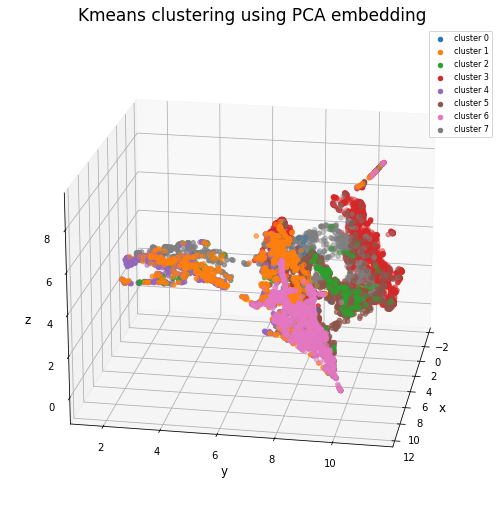

In [106]:
fig = plt.figure(figsize=(9, 9))
ax = fig.add_subplot(projection='3d')
ax.view_init(elev=20, azim=10, vertical_axis='z')

for i in range(k_optimal):
    mask = df['gmm_seleted_features'] == i
    ax.scatter3D(umap_x[mask, 0], umap_x[mask, 1], umap_x[mask, 2], label="cluster {}".format(i))

ax.set_title("Kmeans clustering using PCA embedding", fontsize=17)
ax.set_xlabel('x', fontsize=12)
ax.set_ylabel('y', fontsize=12)
ax.set_zlabel('z', fontsize=12)
# ax.set_xticks([-160, -80, 0, 80, 160, 240])
# ax.set_yticks([-40, 0, 40, 80])
# ax.set_zticks([-40, 0, 40, 80])
plt.legend(fontsize=8)
plt.show()

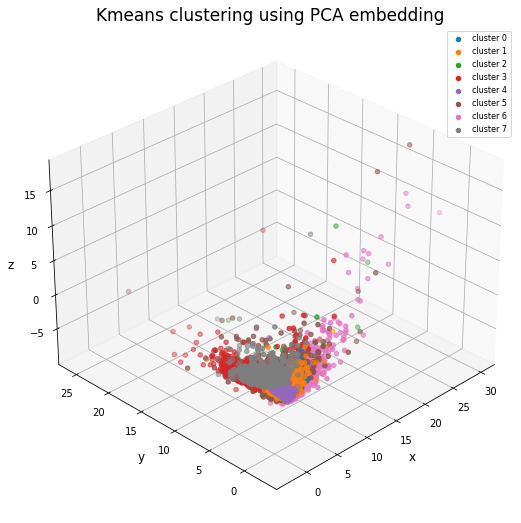

In [107]:
fig = plt.figure(figsize=(9, 9))
ax = fig.add_subplot(projection='3d')
ax.view_init(elev=30, azim=-135, vertical_axis='z')

for i in range(k_optimal):
    mask = df['gmm_seleted_features'] == i
    ax.scatter3D(pca_x[mask, 0], pca_x[mask, 1], pca_x[mask, 2], label="cluster {}".format(i))

ax.set_title("Kmeans clustering using PCA embedding", fontsize=17)
ax.set_xlabel('x', fontsize=12)
ax.set_ylabel('y', fontsize=12)
ax.set_zlabel('z', fontsize=12)
# ax.set_xticks([-160, -80, 0, 80, 160, 240])
# ax.set_yticks([-40, 0, 40, 80])
# ax.set_zticks([-40, 0, 40, 80])
plt.legend(fontsize=8)
plt.show()

In [108]:
# mean vector

gm.means_

array([[-0.5544142, -0.7225934,  0.377891 ,  1.0349183,  0.2212232,
         0.0221289,  0.2037642],
       [-0.5208727, -0.0943481,  0.2936213,  0.0702469,  0.2387014,
        -0.6753489, -0.0444092],
       [ 0.0566903, -0.3341307,  0.4355929, -0.0753739,  0.4729289,
         0.7016135,  0.1513826],
       [ 0.4170452,  0.5180838, -0.881722 , -0.2211884, -0.9169952,
         0.5262912, -0.0400583],
       [-0.7305357, -1.1012943,  0.2545251, -0.6786608,  0.4736546,
        -0.6753489, -0.3821424],
       [ 0.6418737,  0.5180838,  0.6091798,  0.2768026,  0.6260333,
         0.4237815,  0.279576 ],
       [-0.246997 ,  0.5180838,  1.2698432,  0.6834432,  1.2224661,
        -0.6753489,  0.1512858],
       [-0.4253576, -1.2397397, -0.8924741, -0.2356539, -0.9169952,
         0.0366966, -0.1526728]])

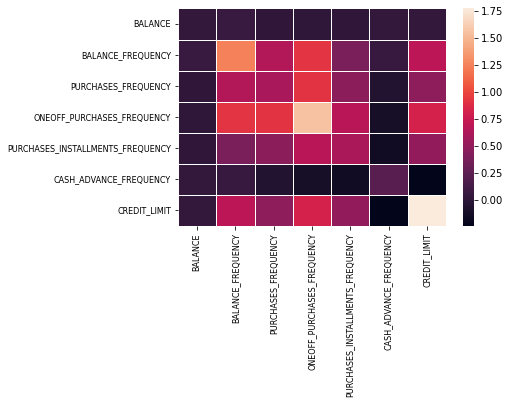

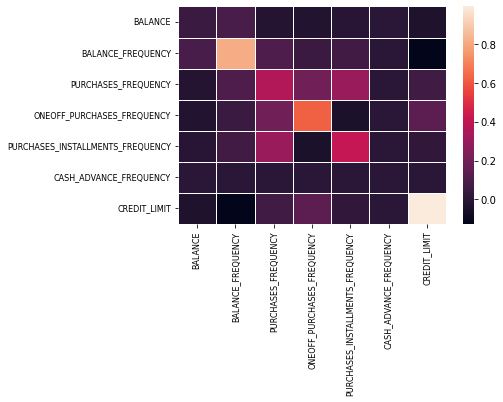

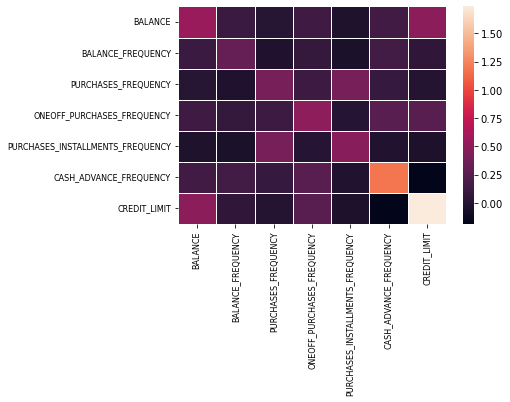

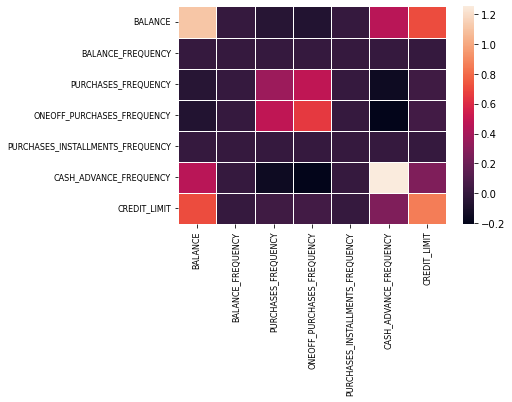

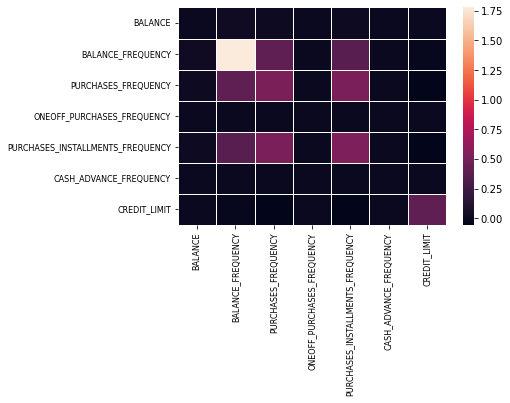

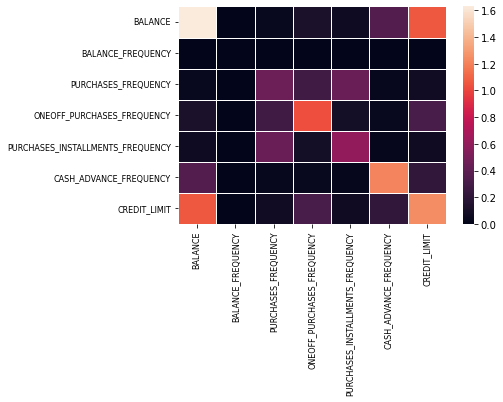

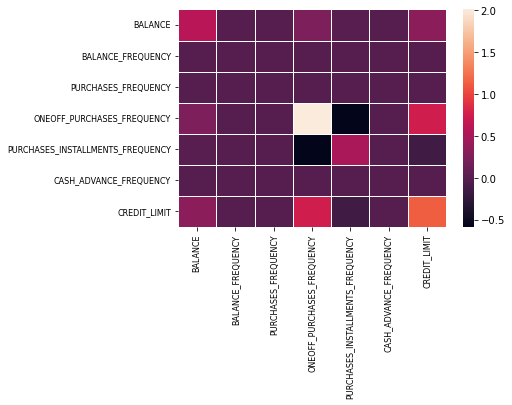

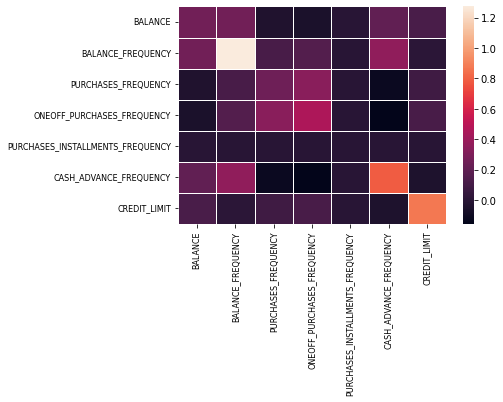

In [109]:
for matrix in gm.covariances_:
    plt.figure(figsize=(6,4))
    sns.heatmap(matrix, linewidths=.5)
    plt.xticks(np.arange(7)+0.5, select_features, rotation=90, fontsize=8)
    plt.yticks(np.arange(7)+0.5, select_features, rotation=0,fontsize=8)
    plt.show()

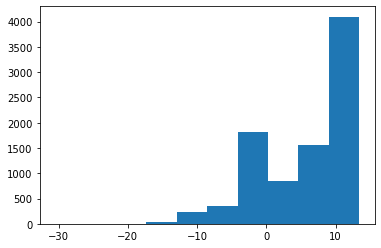

In [110]:
# histogram of log-likelihood of each data sample

plt.figure()
plt.hist(gm.score_samples(X))
plt.show()